### HOMEWORK 01

### 1.1 The IMDB dataset
---
We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews

### 1. Data Load

In [4]:
from torchtext.datasets import IMDB

trainset = IMDB('./data', split='train')
testset = IMDB('./data', split='test')

train_iter = iter(IMDB(split='train'))
print(next(train_iter))
print(len(next(train_iter)[1])) # print the length of the sentence

(1, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(trainset), specials=["<unk>"], min_freq=50)
vocab.set_default_index(vocab["<unk>"])

print(vocab(['here', 'is', 'an', 'example']))

# text_pipeline = lambda x: vocab(tokenizer(x))
# print(text_pipeline('here is an example'))

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

print(text_pipeline('here is an example'))
print(label_pipeline('4'))

[131, 9, 40, 464]
[131, 9, 40, 464]
3


### 2. Data Setting

In [6]:
import torch
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        if sequence<10000:
            results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = text_pipeline(_text)
         processed_text = torch.tensor(vectorize_sequences(processed_text))
         processed_text = torch.sum(processed_text, dim=0)
         processed_text = torch.where(processed_text>0, torch.ones_like(processed_text), torch.zeros_like(processed_text))
         text_list.append(processed_text.view(-1, 10000))
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list, dim=0).float()
    return label_list.to(device), text_list.to(device)#, offsets.to(device)

train_dataset = to_map_style_dataset(trainset)
test_dataset = to_map_style_dataset(testset)
print(len(train_dataset))
print(len(test_dataset))

split_train_, split_valid_ = \
    random_split(train_dataset, [20000, 5000])

train_dataloader = DataLoader(split_train_, batch_size=128,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=128,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=128,
                             shuffle=False, collate_fn=collate_batch)

cuda
25000
25000


### 3. Building Model

In [45]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)   # ← 입력 10000
        self.bn1 = nn.BatchNorm1d(1024)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(1024, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act2 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc3 = nn.Linear(256, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(64, 1)
        self.act4 = nn.Sigmoid()   
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.dropout(self.act1(self.bn1(self.fc1(x))))
        x = self.dropout(self.act2(self.bn2(self.fc2(x))))
        x = self.dropout(self.act3(self.bn3(self.fc3(x))))
        x = self.act4(self.fc4(x))               # ← Sigmoid 없음, 로짓
        return x
    
model = Model().to(device)

In [46]:
import torch.optim as optim
import sklearn.metrics

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
metrics = sklearn.metrics.accuracy_score

In [47]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

### 4. Training & Validation

In [49]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(15):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    # -------- train --------
    model.train()
    for i, (labels, inputs) in enumerate(train_dataloader, 0):
        inputs = inputs.to(device)
        labels = labels.to(device).view(-1, 1).float()

        optimizer.zero_grad()
        outputs = model(inputs)                 # (B,1) 확률 (Sigmoid 포함 모델 가정)
        loss = criterion(outputs, labels)       # BCELoss 가정
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += ((outputs > 0.5) == (labels > 0.5)).sum()
        running_total += labels.size(0)

    # -------- valid --------
    model.eval()
    with torch.no_grad():
        for i, (labels, inputs) in enumerate(valid_dataloader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1, 1).float()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            running_val_correct += ((outputs > 0.5) == (labels > 0.5)).sum()
            running_val_total += labels.size(0)

    # 에폭 평균 지표
    train_loss_epoch = running_loss / len(train_dataloader)
    train_acc_epoch  = (running_correct / running_total).item()
    val_loss_epoch   = running_val_loss / len(valid_dataloader)
    val_acc_epoch    = (running_val_correct / running_val_total).item()

    print(f'[{epoch + 1:02d}] '
          f'loss: {train_loss_epoch:.3f}, acc: {train_acc_epoch:.4f}, '
          f'val_loss: {val_loss_epoch:.3f}, val_acc: {val_acc_epoch:.4f}')

    history['loss'].append(train_loss_epoch)
    history['acc'].append(train_acc_epoch)
    history['val_loss'].append(val_loss_epoch)
    history['val_acc'].append(val_acc_epoch)

print('Finished Training')

[01] loss: 0.114, acc: 0.9585, val_loss: 0.419, val_acc: 0.8670
[02] loss: 0.067, acc: 0.9760, val_loss: 0.470, val_acc: 0.8662
[03] loss: 0.050, acc: 0.9821, val_loss: 0.513, val_acc: 0.8676
[04] loss: 0.035, acc: 0.9877, val_loss: 0.571, val_acc: 0.8682
[05] loss: 0.031, acc: 0.9887, val_loss: 0.590, val_acc: 0.8654
[06] loss: 0.032, acc: 0.9903, val_loss: 0.652, val_acc: 0.8602
[07] loss: 0.030, acc: 0.9893, val_loss: 0.591, val_acc: 0.8686
[08] loss: 0.020, acc: 0.9937, val_loss: 0.646, val_acc: 0.8644
[09] loss: 0.017, acc: 0.9938, val_loss: 0.684, val_acc: 0.8662
[10] loss: 0.018, acc: 0.9941, val_loss: 0.651, val_acc: 0.8680
[11] loss: 0.016, acc: 0.9949, val_loss: 0.710, val_acc: 0.8658
[12] loss: 0.014, acc: 0.9955, val_loss: 0.687, val_acc: 0.8688
[13] loss: 0.009, acc: 0.9967, val_loss: 0.795, val_acc: 0.8596
[14] loss: 0.009, acc: 0.9969, val_loss: 0.804, val_acc: 0.8698
[15] loss: 0.010, acc: 0.9965, val_loss: 0.758, val_acc: 0.8650
Finished Training


### 5. Visualization

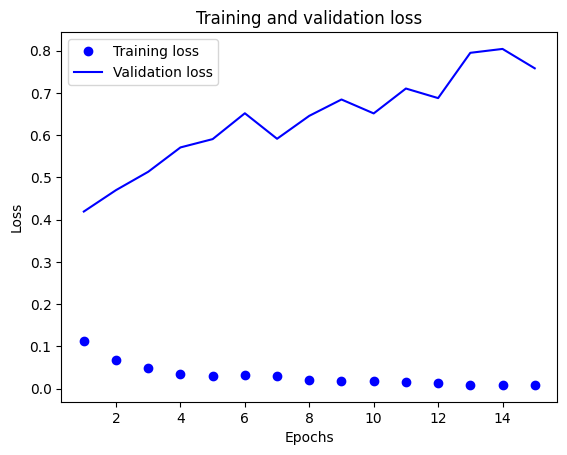

In [50]:
import matplotlib.pyplot as plt

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

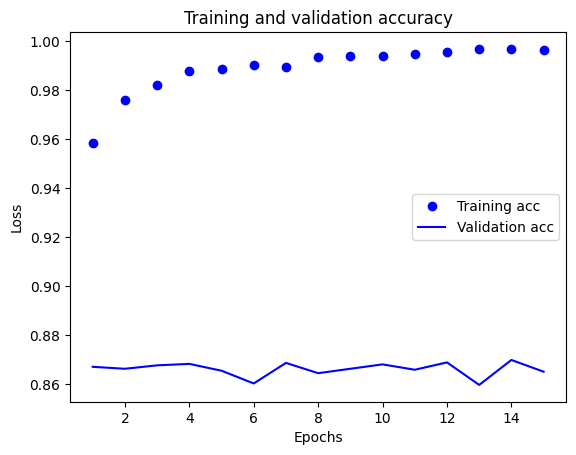

In [51]:
plt.clf()   # clear figure
acc_values = acc
val_acc_values = val_acc

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 6. Test

In [53]:
model.eval()
running_test_loss = 0.0
running_test_correct = 0
running_test_total = 0

is_cuda = (device.type == 'cuda')  # ← use_cuda 대신

with torch.no_grad():
    for labels, inputs in test_dataloader:
        inputs = inputs.to(device, non_blocking=is_cuda).float()
        labels = labels.to(device, non_blocking=is_cuda).view(-1, 1).float()

        # FP16 안전: forward만 AMP, loss는 FP32
        with torch.cuda.amp.autocast(enabled=is_cuda):
            probs = model(inputs)  # (B,1), Sigmoid 포함 모델의 확률

        with torch.cuda.amp.autocast(enabled=False):
            loss = criterion(probs.float(), labels)  # BCELoss in FP32

        bs = labels.size(0)
        running_test_loss   += loss.item() * bs
        running_test_correct += (probs >= 0.5).long().eq(labels.long()).sum().item()
        running_test_total   += bs

avg_test_loss = running_test_loss / running_test_total
avg_test_acc  = running_test_correct / running_test_total
print(f"Test Loss: {avg_test_loss:.3f}, Test Accuracy: {avg_test_acc:.4f}")

Test Loss: 1.522, Test Accuracy: 0.8597


### 1.2 Classifying newswires: a multi-class classification example
---
Instead of using *Reuters dataset* in Keras example, we use *AG News dataset*.


### 1. Data Load

In [54]:
from torchtext.datasets import AG_NEWS

trainset = AG_NEWS('./data', split='train')
testset = AG_NEWS('./data', split='test')

train_iter = iter(AG_NEWS(split='train'))
print(next(train_iter))
print(len(next(train_iter)[1])) # print the length of the sentence

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
266


In [55]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(trainset), specials=["<unk>"], min_freq=50)
vocab.set_default_index(vocab["<unk>"])

print(vocab(['here', 'is', 'an', 'example']))

# text_pipeline = lambda x: vocab(tokenizer(x))
# print(text_pipeline('here is an example'))

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

print(text_pipeline('here is an example'))
print(label_pipeline('4'))

[475, 21, 30, 5297]
[475, 21, 30, 5297]
3


### 2. Data Setting

In [56]:
import torch
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        if sequence<10000:
            results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = text_pipeline(_text)
         processed_text = torch.tensor(vectorize_sequences(processed_text))
         processed_text = torch.sum(processed_text, dim=0)
         processed_text = torch.where(processed_text>0, torch.ones_like(processed_text), torch.zeros_like(processed_text))
         text_list.append(processed_text.view(-1, 10000))
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list, dim=0).float()
    return label_list.to(device), text_list.to(device)#, offsets.to(device)

train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

split_train_, split_valid_ = \
    random_split(train_dataset, [60000, 60000])

train_dataloader = DataLoader(split_train_, batch_size=128,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=128,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=128,
                             shuffle=False, collate_fn=collate_batch)

cuda


### 3. Building Model

In [60]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10000, 1024)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(1024, 256)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(256, 64)
        self.act3 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        self.fc4 = nn.Linear(64, 4)
        self.act4 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        # there is no softmax function since softmax function will be automatically applied inside of the cross-entropy loss provided by pytorch


    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)

        return x
        
model = Model()
model.to(device)

Model(
  (fc1): Linear(in_features=10000, out_features=1024, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (act2): ReLU()
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (act3): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=64, out_features=4, bias=True)
  (act4): ReLU()
)

In [61]:
import torch.optim as optim

optimizer = optim.RMSprop(params = model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [63]:
history = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(15):
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [labels, inputs]
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = outputs.max(dim=1)
        # print(preds)
        # print statistics
        running_loss += loss.item()
        running_correct += (preds == labels).sum()
        running_total += labels.size(0)
        # print(running_correct/running_total)


    for i, data in enumerate(valid_dataloader):
        labels, inputs = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(dim=1)

        running_val_loss += loss.item()
        running_val_correct += (preds == labels).sum()          
        running_val_total += labels.size(0)

    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_dataloader):.3f}, accuracy: {running_correct/running_total:.4f}, val_loss: {running_val_loss / len(valid_dataloader):.3f}, valid accuracy: {running_val_correct/running_val_total:.4f}')

    history['loss'].append(running_loss / len(train_dataloader))
    history['acc'].append((running_correct/running_total).item())
    history['val_loss'].append(running_val_loss / len(valid_dataloader))
    history['val_acc'].append((running_val_correct/running_val_total).item())

    # print(outputs)
print('Finished Training')

[1,   469] loss: 0.179, accuracy: 0.9430, val_loss: 0.291, valid accuracy: 0.9094
[2,   469] loss: 0.076, accuracy: 0.9768, val_loss: 0.385, valid accuracy: 0.9073
[3,   469] loss: 0.036, accuracy: 0.9897, val_loss: 0.537, valid accuracy: 0.9033
[4,   469] loss: 0.028, accuracy: 0.9932, val_loss: 0.708, valid accuracy: 0.8996
[5,   469] loss: 0.025, accuracy: 0.9940, val_loss: 0.753, valid accuracy: 0.9068
[6,   469] loss: 0.023, accuracy: 0.9948, val_loss: 0.743, valid accuracy: 0.9056
[7,   469] loss: 0.024, accuracy: 0.9953, val_loss: 0.709, valid accuracy: 0.9019
[8,   469] loss: 0.021, accuracy: 0.9958, val_loss: 0.879, valid accuracy: 0.8964
[9,   469] loss: 0.021, accuracy: 0.9964, val_loss: 1.041, valid accuracy: 0.9059
[10,   469] loss: 0.019, accuracy: 0.9966, val_loss: 1.044, valid accuracy: 0.9035
[11,   469] loss: 0.017, accuracy: 0.9967, val_loss: 1.002, valid accuracy: 0.9001
[12,   469] loss: 0.021, accuracy: 0.9962, val_loss: 1.347, valid accuracy: 0.9031
[13,   469] l

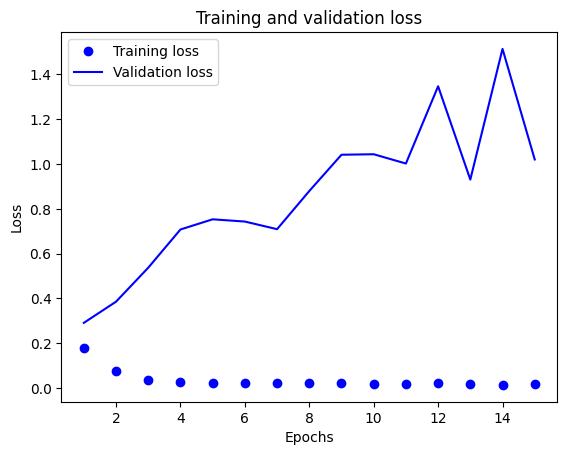

In [64]:
import matplotlib.pyplot as plt

loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

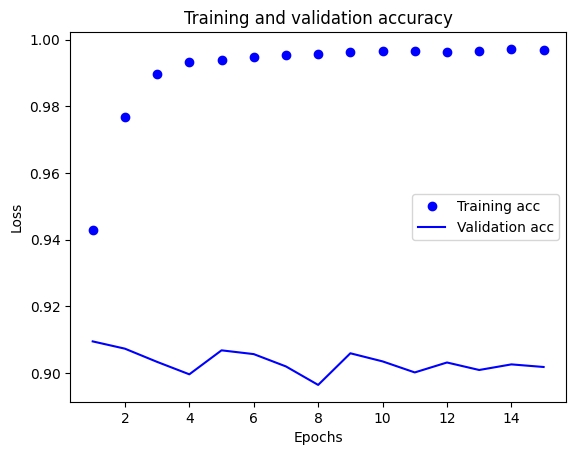

In [65]:
plt.clf()   # clear figure

acc = history['acc']
val_acc = history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [68]:
running_test_loss = 0
running_test_correct = 0
running_test_total = 0


for i, data in enumerate(test_dataloader):
    labels, inputs = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = outputs.max(dim=1)

    running_test_loss += loss.item()
    running_test_correct += (preds == labels).sum()          
    running_test_total += labels.size(0)

print(f'test loss: {running_loss / len(test_dataloader):.3f}, test accuracy: {running_test_correct/running_test_total:.4f}')

test loss: 0.127, test accuracy: 0.8937


**Show prediction result**

In [67]:
data = next(iter(test_dataloader))
labels, inputs = data
inputs = inputs.to(device)
labels = labels.to(device)

predictions = model(inputs)
print(predictions[0], predictions[0].shape)
softmax_predictions = torch.softmax(predictions, dim=1)
print(softmax_predictions[0], softmax_predictions[0].shape)

tensor([-25.6510, -26.9854,   8.8930, -14.0606], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([4])
tensor([9.9478e-16, 2.6194e-16, 1.0000e+00, 1.0750e-10], device='cuda:0',
       grad_fn=<SelectBackward0>) torch.Size([4])
